# Logistic Regression Model 

Logistic Regression is a statistical method used for binary classification tasks, where the objective is to predict the probability of an event occurring or not. The algorithm is more of classification rather than a regression one. It models the relationship between independent variables and the probability of a particular outcome using the logistic function. Logistic Regression is widely utilized in various fields for its simplicity, interpretability, and effectiveness in scenarios where the response variable is categorical with two classes.

# Goal is to predict next day will be up day(1) or down day(0)

In [38]:
#Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf


# Historical data

In [39]:
#download data
df = yf.download("TCS",start ='2013-12-31',end ='2023-12-30')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,46.290001,47.070000,45.599998,46.610001,43.570217,460800
2014-01-02,46.869999,46.869999,43.779999,43.779999,40.924782,798800
2014-01-03,44.790001,45.180000,41.779999,42.660000,39.877827,1247300
2014-01-06,44.669998,45.000000,42.759998,42.980000,40.176956,1101300
2014-01-07,43.840000,45.790001,43.119999,45.790001,42.803696,1677300
...,...,...,...,...,...,...
2023-12-22,2.340000,2.450000,2.300000,2.320000,2.320000,243400
2023-12-26,2.330000,2.520000,2.310000,2.470000,2.470000,286600
2023-12-27,2.430000,2.440000,2.330000,2.340000,2.340000,412000


In [40]:
# Make the copy of the data. will work on the copied data.
data = df.copy()

### Generate Target Values

We want to predict the next days movement: up(1) or down(0). 

This is a classification task. And for that purpose, we will create our target values. 

In [41]:
# Generate log returns
data['returns'] = np.log(data['Close'] / data['Close'].shift(1))

If the next day is up day, we will designate it with 1, else if it is a down day, we will mark it with -1.

In [42]:
# Create target values
data['target'] = np.where(data['returns'].shift(-1) > 0, 1, 0)

In [43]:
data['target'].value_counts()

0    1347
1    1170
Name: target, dtype: int64

In [44]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume,returns,target
Date,,,,,,,,
2013-12-31,46.290001,47.070000,45.599998,46.610001,43.570217,460800,NaN,0
2014-01-02,46.869999,46.869999,43.779999,43.779999,40.924782,798800,-0.062638,0
2014-01-03,44.790001,45.180000,41.779999,42.660000,39.877827,1247300,-0.025915,1


In [45]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)

# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].ewm(span=i, adjust=False).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Feature based on volume
col_name = 'vma_4'
data[col_name] = data['Volume'].rolling(4).mean()
features_list.append(col_name)

# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

In [46]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'vma_4',
 'co']

In [47]:
# Removing nan values
data.dropna(inplace=True)

In [48]:
data[features_list + ['target']].head()

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co,target
Date,,,,,,,,,,,,,
2014-01-22,0.442098,0.495419,2.927131,39.525369,40.473924,41.274947,41.918251,-0.012318,-0.016081,-0.013100,398000.0,-0.070000,0
2014-01-23,0.323187,0.535165,2.476759,39.248029,40.164683,40.963047,41.616847,-0.009886,-0.003990,-0.000962,328600.0,-0.740002,0
2014-01-24,0.241599,0.553671,2.298874,39.012024,39.887848,40.676090,41.334782,-0.012505,-0.037260,-0.037711,369000.0,-0.049999,0
2014-01-27,0.307977,0.533218,2.187110,38.780747,39.619367,40.396463,41.058261,-0.018039,-0.030357,-0.034119,341800.0,-0.320000,0
2014-01-28,0.732918,0.768844,2.049533,38.364248,39.228197,40.024419,40.706856,-0.039971,-0.049857,-0.043961,401450.0,-1.549999,0


In [49]:
from sklearn.model_selection import train_test_split

In [50]:
#splitting data into train and test
X_train , X_test, y_train, y_test = train_test_split(data[features_list].iloc[:-1],
                                                    data.iloc[:-1]['target'],
                                                    test_size= 0.25, 
                                                    shuffle=False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1876, 12), (1876,), (626, 12), (626,))

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
# Scaling the features
scaler = StandardScaler()
# An instance of the StandardScaler class is created. This scaler will be used to standardize the features.

X_train_scaled = scaler.fit_transform(X_train)
# fit is calculating zscore and calculate statistical varaibles
X_test_scaled = scaler.transform(X_test)
# and as x_test is testing data we will keep it hidden and not calculate zscore

The fit_transform method is used on the training data (X_train) to compute the mean and standard deviation necessary for standardization and then applies the transformation. The same transformation (using transform) is applied to the testing data (X_test). This ensures that both training and testing sets are scaled using the same mean and standard deviation.

Brings standard deviation and mean to 1

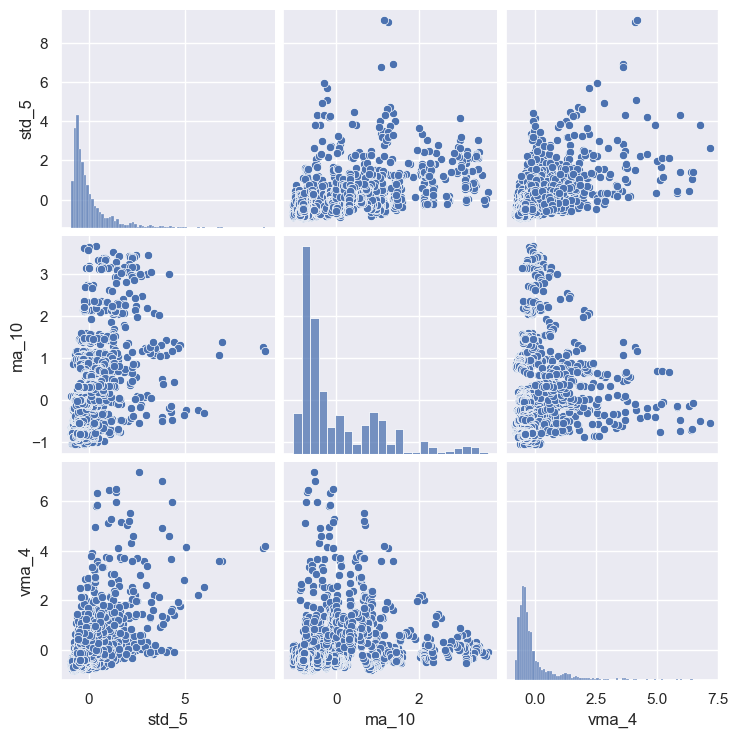

In [53]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#The scaled training data is converted to a DataFrame (X_train_scaled_df) to facilitate visualization and analysis. 
#The columns are named after the original features.

sns.pairplot(X_train_scaled_df[['std_5', 'ma_10', 'vma_4']])

In [54]:
X_train_scaled_df.describe().round(2)

#This can be useful for better readability, as the features become rows and the summary statistics become columns.

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
count,1876.00,1876.00,1876.00,1876.00,1876.00,1876.00,1876.00,1876.00,1876.00,1876.00,1876.00,1876.00
mean,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.91,-0.98,-1.03,-1.04,-1.04,-1.03,-1.02,-6.13,-4.89,-4.16,-0.81,-6.64
25%,-0.61,-0.65,-0.68,-0.69,-0.69,-0.68,-0.68,-0.47,-0.49,-0.51,-0.52,-0.36
50%,-0.33,-0.33,-0.30,-0.47,-0.48,-0.48,-0.49,-0.04,-0.02,-0.03,-0.34,-0.01
75%,0.21,0.29,0.26,0.62,0.63,0.61,0.58,0.41,0.39,0.42,0.03,0.37
max,9.19,6.46,5.29,3.67,3.75,3.81,3.85,7.23,5.19,5.01,7.18,5.31


In [55]:
# Import necessary package
from sklearn.linear_model import LogisticRegression

In [56]:
LogisticRegression?

In [57]:
# define model
model = LogisticRegression(random_state=1)

In [58]:
# Train model
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [59]:
# Predict on a train dataset
y_pred_train = model.predict(X_train_scaled)

In [60]:
print('Model accuracy on training data:', model.score(X_train_scaled, y_train))

Model accuracy on training data: 0.5421108742004265


In [61]:
# Predict on a test dataset
y_pred = model.predict(X_test_scaled)

In [62]:
print('Model accuracy on testing data:', model.score(X_test_scaled, y_test))

Model accuracy on testing data: 0.5335463258785943


In [63]:
# Another method to calculate accuracy
from sklearn.metrics import accuracy_score ,  precision_score, recall_score, f1_score

print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Evaluate the model


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Model accuracy on training data: 0.5421108742004265
Model accuracy on testing data: 0.5335463258785943
Precision: 0.509090909090909
Recall: 0.09556313993174062
F1 Score: 0.16091954022988508


In [64]:
# Importing necessary packages
from sklearn.metrics import confusion_matrix, classification_report

In [65]:
# Printing the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[306  27]
 [265  28]]


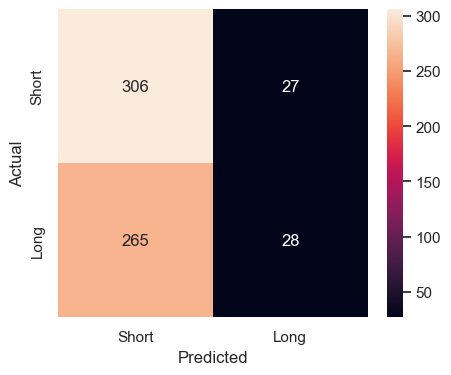

In [66]:
# Plotting the Confustion matrix
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm, index=['Short', 'Long'], columns=['Short', 'Long'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [67]:
# Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.92      0.68       333
           1       0.51      0.10      0.16       293

    accuracy                           0.53       626
   macro avg       0.52      0.51      0.42       626
weighted avg       0.52      0.53      0.44       626

